# Finite Time Lyapunov Exponent (FTLE) analysis
### Author: Justine John (JJ) A. Serdoncillo 
### Date Created: August 7, 2023
---

# <font color='289C4E'>Table of contents<font><a class='anchor' id='top'></a>
1. [Yuanhang Functions](#1)
2. [Read Data](#2)
3. [Particle Tracking](#3)
4. [FTLE Calculation](#4)
5. [Visualization](#5)
6. [Save Data](#6)

## PIV Experimental data for hydrofoil pitching at the leading edge at $Re = 10,000$ and $St = 0.2518$

### Airfoil kinematics: $\theta = \theta_0 + \Delta \theta sin(2\pi f^*t)$, where $f = 2.4 Hz $, $U = 0.125 m/s$, $\Delta \theta = 5^{\circ}$, $\theta_0 = 0^{\circ}$, chord length = 8 cm, Pitching axis = 0.47625 cm behind leading edge
***
***

In [1]:
using FileIO, ImageMagick, Colors, FixedPointNumbers, DelimitedFiles, PyPlot, LinearAlgebra, HDF5
println("DONE")

DONE


## <font color='289C4E'>Yuanhang Functions<font><a id='1'></a>


In [2]:
# Read the PIV velocity data of a 2D pitching foil
# Calculate the vorticity and Q value
# Plot the vorticity, Q, influence potential, and vorticity-induced force/moment density
# Yuanhang Zhu
# Aug 1, 2023

function calculate_vorticity_Q(x::Matrix{T}, y::Matrix{T}, u::Matrix{T}, v::Matrix{T}) where T
    nx, ny = size(u,2), size(u,1)
    vorticity = similar(u, T)
    q_value = similar(u, T)
    
    for j in 2:(ny-1)
        for i in 2:(nx-1)
            dv_dx = (v[j, i+1] - v[j, i-1]) / (x[j, i+1] - x[j, i-1])
            du_dy = (u[j+1, i] - u[j-1, i]) / (y[j+1, i] - y[j-1, i])
            
            # Calculate rate of strain tensor components
            ds_dx = 0.5 * (du_dy + dv_dx)
            du_dx = (u[j, i+1] - u[j, i-1]) / (x[j, i+1] - x[j, i-1])
            dv_dy = (v[j+1, i] - v[j-1, i]) / (y[j+1, i] - y[j-1, i])
            ds_dy = 0.5 * (du_dx + dv_dy)
            
            # Calculate vorticity
            vorticity[j, i] = dv_dx - du_dy

            # Calculate Q values
            # q_value[j, i] = 0.5 * (vorticity[j, i]^2 + ds_dx^2 + ds_dy^2)
            q_value[j, i] = -du_dy * dv_dx + du_dx * dv_dy
        end
    end
    
    return vorticity, q_value
end

calculate_vorticity_Q (generic function with 1 method)

### Load Airfoil Coordinates - changed directory

In [ ]:
cd("C:/Users/justi/OneDrive - Syracuse University/Documents/2D_PIV_pitching_foil_YZ/foil shape") # load foil coordinates

shape = readdlm("foil_coordinate_1.txt", ',', '\n')
xfoil = shape[:,1];
yfoil = shape[:,2];

### Load Velocity Field Data - changed directory

In [ ]:
cd("C:/Users/justi/OneDrive - Syracuse University/Documents/2D_PIV_pitching_foil_YZ/PIV data") # load velocity field data

velocity_data = readdlm("velocity_field_1.txt", ',', '\n')

xn = 119; # number of values in x-direction
yn = 81; # number of values in y-direction

x = velocity_data[:,1];
y = velocity_data[:,2];
u = velocity_data[:,3];
v = velocity_data[:,4];

xdata = reshape(x, (xn, yn));
ydata = reshape(y, (xn, yn));
udata = reshape(u, (xn, yn));
vdata = reshape(v, (xn, yn));

vorticity, q_value = calculate_vorticity_Q(ydata, xdata, -vdata, -udata);

## <font color='289C4E'>Read Data<font><a id='2'></a>
### Reading all the data at once 

In [3]:
cd("C:/Users/justi/OneDrive - Syracuse University/Documents/2D_PIV_pitching_foil_YZ/PIV data")
velocity_data = readdlm("velocity_field_1.txt", ',', '\n')
x = velocity_data[:,1];
y = velocity_data[:,2];

xn = 119; # number of values in x-direction
yn = 81; # number of values in y-direction

xdata = reshape(x, (xn, yn));
ydata = reshape(y, (xn, yn));
x_range = xdata[:,1]
y_range = ydata[1,:]

tstep_start = 0
periods = 4
tstep_end = 4/2.4
og_num_tsteps = 50 
num_tsteps = og_num_tsteps * periods
tstep_delta = 1/(2.4*50)
Vel_contour = zeros(Float64, 2, num_tsteps * periods, yn, xn)

for p in 0:periods-1
    for num in 1:og_num_tsteps
        velocity_data = readdlm("velocity_field_$num.txt", ',', '\n')
        u = velocity_data[:,3];
        v = velocity_data[:,4];
    
        Vel_contour[1, p*og_num_tsteps+num, :, :] =  transpose(reshape(u,(xn, yn)))
        Vel_contour[2, p*og_num_tsteps+num, :, :] =  transpose(reshape(v,(xn, yn)))
    end
end

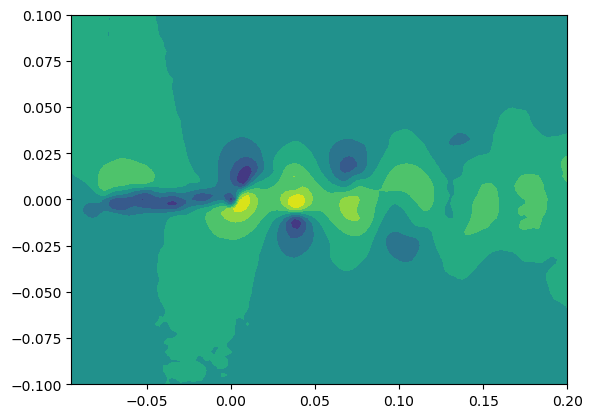

PyObject <matplotlib.contour.QuadContourSet object at 0x0000023559B24E20>

In [4]:
fig, ax = plt.subplots()
ax.contourf(x_range, y_range, Vel_contour[1,1,:,:])

### Plot Vorticity Field

fig, ax = plt.subplots()
ax.contourf(xdata[2:end-1,1], ydata[1,2:end-1], max.(min.(q_value[2:end-1,2:end-1]', 100), -100), levels=100, lw=0, xlabel="x (m)", ylabel="y (m)", title="Q", color=:vik, aspect_ratio=:equal, clim=(-100,100), xlims=(-0.1, 0.2), ylims=(-0.1,0.1));
ax.plot(xfoil,yfoil,fill=true,aspect_ratio=:equal,c=:black,legend = false)

### Load Phi Field data - changed directory

#cd("/Users/yuanhangzhu/Dropbox/Research/UVA/FMPM/2D PIV case/Potential/drag_potential")
cd("E:/Research/2D_PIV_pitching_foil_YZ/Potential/drag_potential")
phi_drag = readdlm("phi_drag_$num.txt", ',', '\n')[:,3]; # load phi field data
phi_drag_data = reshape(phi_drag, (yn, xn))

p3 = contourf(xdata[2:end-1,1], ydata[1,2:end-1], phi_drag_data[2:end-1,2:end-1], levels=50, lw=0, xlabel="x (m)", ylabel="y (m)", title="Phi", color=:vik, aspect_ratio=:equal, clim=(-0.01,0.01), xlims=(-0.1, 0.2), ylims=(-0.1,0.1));
plot!(xfoil,yfoil,fill=true,aspect_ratio=:equal,c=:black,legend = false)

drag_density = -2*.*(q_value',phi_drag_data) # calculate vorticity-induced force density
p3 = contourf(xdata[2:end-1,1], ydata[1,2:end-1], max.(min.(drag_density[2:end-1,2:end-1], 0.2), -0.2), levels=50, lw=0, xlabel="x (m)", ylabel="y (m)", title="Drag density", color=:vik, aspect_ratio=:equal, clim=(-0.2,0.2), xlims=(-0.1, 0.2), ylims=(-0.1,0.1));
plot!(xfoil,yfoil,fill=true,aspect_ratio=:equal,c=:black,legend = false)

## <font color='289C4E'>Particle Tracking and FTLE calculation<font><a id='3'></a>

In [7]:
function find_me(xval, yval)
    x1 = argmin(abs.(x_range .- xval))
    y1 = argmin(abs.(y_range .- yval))

    if x1 >= size(x_range)[1]-1
        x1 -= 3
    end
    
    if y1 >= size(y_range)[1]-1
        y1 -= 3
    end

    x2 = x1 + 1
    y2 = y1 + 1
    
    return x1, x2, y1, y2
end
tstep_range = collect(range(tstep_start, tstep_end, length=num_tsteps))
print("DONE")

DONE

In [19]:
function FTLE(nx,ny,x0,x1,y0,y1,t_0,t_1)
    nx = Int64(nx)
    ny = Int64(ny)
    move = Int64(sign(t_1-t_0))
    t_0_ind = Int64(argmin(abs.(tstep_range .- t_0)))
    t_1_ind = Int64(argmin(abs.(tstep_range .- t_1)))
    tsteps = Int64(round(abs(t_1 - t_0)/tstep_delta + 1))
    x = collect(range(x0, x1, length=nx))
    y = collect(range(y0, y1, length=ny))
    particles = zeros(3, tsteps+1, nx, ny)

    for ii in 1:nx, jj in 1:ny
        particles[1,1,ii, :] .= x[ii]
        particles[2,1, :,jj] .= y[jj]
    end
    
    x = copy(x_range)
    y = copy(y_range)
    # Iterate through all timesteps 
    data =  "C:/Users/justi/Documents/data_JJ"
    count = 1
    for tt in t_0_ind:move:t_1_ind
        if count % (tsteps/4) == 0
            name = string(nx) * "_" * string(ny) * "_" * string(Int64(round(t_0))) * "_" * string(Int64(round(t_1))) * "_" * string(count) *".h"
            h5open(joinpath(data,name), "w") do file
                write(file, "A", particles[:,tt,:,:])
            end
        end
        for ii in 1:nx, jj in 1:ny
            for jj in 1:ny
                # Let's use Runge Kutta 4th order
                kxy = zeros(4,2)
                a = particles[1,Int64(move*(tt-t_0_ind)+1),ii,jj]
                b = particles[2,Int64(move*(tt-t_0_ind)+1),ii,jj]
                #=Runge Kutta 4th Order K1 =#
                c = copy(a)
                d = copy(b)
                x1, x2, y1, y2 = find_me(c, d)
                for UV in 1:2
                    kxy[1,UV] = 1/((y[y2]-y[y1])*(x[x2]-x[x1])) * ( 
                                (x[x2]-c)*(y[y2]-d)*Vel_contour[UV,tt,y1,x1] + 
                                (c-x[x1])*(y[y2]-d)*Vel_contour[UV,tt,y2,x1] +
                                (x[x2]-c)*(d-y[y1])*Vel_contour[UV,tt,y1,x2] +
                                (c-x[x1])*(d-y[y1])*Vel_contour[UV,tt,y2,x2] )
                end
                #=Runge Kutta 4th Order K2 =#
                c = a + 0.5*kxy[1,1]*tstep_delta
                d = b + 0.5*kxy[1,2]*tstep_delta
                x1, x2, y1, y2 = find_me(c, d)
                for UV in 1:2
                    kxy[2,UV] = 1/((y[y2]-y[y1])*(x[x2]-x[x1])) * ( 
                                (x[x2]-c)*(y[y2]-d)*0.5*(Vel_contour[UV,tt,y1,x1]+Vel_contour[UV,tt+move,y1,x1]) + 
                                (c-x[x1])*(y[y2]-d)*0.5*(Vel_contour[UV,tt,y2,x1]+Vel_contour[UV,tt+move,y2,x1]) +
                                (x[x2]-c)*(d-y[y1])*0.5*(Vel_contour[UV,tt,y1,x2]+Vel_contour[UV,tt+move,y1,x2]) +
                                (c-x[x1])*(d-y[y1])*0.5*(Vel_contour[UV,tt,y2,x2]+Vel_contour[UV,tt+move,y2,x2]) )
                end
                #=Runge Kutta 4th Order K3 =#
                c = a + 0.5*kxy[2,1]*tstep_delta
                d = b + 0.5*kxy[2,2]*tstep_delta
                x1, x2, y1, y2 = find_me(c, d)
                for UV in 1:2
                    kxy[3,UV] = 1/((y[y2]-y[y1])*(x[x2]-x[x1])) * ( 
                                (x[x2]-c)*(y[y2]-d)*0.5*(Vel_contour[UV,tt,y1,x1]+Vel_contour[UV,tt+move,y1,x1]) + 
                                (c-x[x1])*(y[y2]-d)*0.5*(Vel_contour[UV,tt,y2,x1]+Vel_contour[UV,tt+move,y2,x1]) +
                                (x[x2]-c)*(d-y[y1])*0.5*(Vel_contour[UV,tt,y1,x2]+Vel_contour[UV,tt+move,y1,x2]) +
                                (c-x[x1])*(d-y[y1])*0.5*(Vel_contour[UV,tt,y2,x2]+Vel_contour[UV,tt+move,y2,x2]) )
                end
                #=Runge Kutta 4th Order K4 =#
                c = a + kxy[3,1]*tstep_delta
                d = b + kxy[3,2]*tstep_delta
                x1, x2, y1, y2 = find_me(c, d)
                for UV in 1:2
                    kxy[4,UV] = 1/((y[y2]-y[y1])*(x[x2]-x[x1])) * ( 
                                (x[x2]-c)*(y[y2]-d)*Vel_contour[UV,tt+move,y1,x1] + 
                                (c-x[x1])*(y[y2]-d)*Vel_contour[UV,tt+move,y2,x1] +
                                (x[x2]-c)*(d-y[y1])*Vel_contour[UV,tt+move,y1,x2] +
                                (c-x[x1])*(d-y[y1])*Vel_contour[UV,tt+move,y2,x2] )
                end
                for UV in 1:2
                    particles[UV,Int64(move*(tt-t_0_ind)+2),ii,jj] = particles[UV,Int64(move*(tt-t_0_ind)+1),ii,jj] + sign(move)*(kxy[1,UV]+2*kxy[2,UV]+2*kxy[3,UV]+kxy[4,UV])*tstep_delta/6
                end
            end
        end
        count += 1
    end
    
    
    for tt in 1:tsteps
        for ii in 2:nx-1
            for jj in 2:ny-1
                ul = (particles[1,tt,ii+1,jj]-particles[1,tt,ii-1,jj])/(particles[1,1,ii+1,jj]-particles[1,1,ii-1,jj])
                ur = (particles[2,tt,ii+1,jj]-particles[2,tt,ii-1,jj])/(particles[2,1,ii,jj+1]-particles[2,1,ii,jj-1])
                ll = (particles[1,tt,ii,jj+1]-particles[1,tt,ii,jj-1])/(particles[1,1,ii+1,jj]-particles[1,1,ii-1,jj])
                lr = (particles[2,tt,ii,jj+1]-particles[2,tt,ii,jj-1])/(particles[2,1,ii,jj+1]-particles[2,1,ii,jj-1])
                B = [ul ur; ll lr]
                A = transpose(B) * B
                G = eigvals(A)
                H = ones(length(G))
                for i in 1:length(H)
                    H[i] = abs(G[i])
                end
                sigma = maximum(H)
                particles[3,tt+1,ii,jj] = 0.5/tstep_delta*log(sigma)
            end
        end
    end
    
    
    flow = particles[:,:,2:nx-1,2:ny-1]
    println("done")

    data =  "C:/Users/justi/Documents/data_JJ"
    name = string(nx) * "_" * string(ny) * "_" * string(Int64(round(t_0))) * "_" * string(Int64(round(t_1))) * "finished.h"
    h5open(joinpath(data,name), "w") do file
        write(file, "A", flow)
    end

    return flow
end

FTLE (generic function with 1 method)

```{admonition}
Example: FTLE for forward and then backward along one cycle
```

In [21]:
p = FTLE(100,100,-0.05,0.1,-0.05,0.05,     0*tstep_delta, 100*tstep_delta)
n = FTLE(100,100,-0.05,0.1,-0.05,0.05,   200*tstep_delta, 100*tstep_delta)
print("DONE")

done
done
DONE

In [ ]:
p1 = FTLE(500,500,-0.05,0.1,-0.05,0.05,     0*tstep_delta, 100*tstep_delta)
n1 = FTLE(500,500,-0.05,0.1,-0.05,0.05,   200*tstep_delta, 100*tstep_delta)
print("DONE")

In [ ]:
data =  "C:/Users/justi/Documents/data_JJ"
name = "pYZ_500_500.h"
h5open(joinpath(data,name), "w") do file
    write(file, "A", p)
end
name = "nYZ_500_500.h"
h5open(joinpath(data,name), "w") do file
    write(file, "A", n)
end
print("DONE")

In [23]:
size(p)

(3, 102, 98, 98)

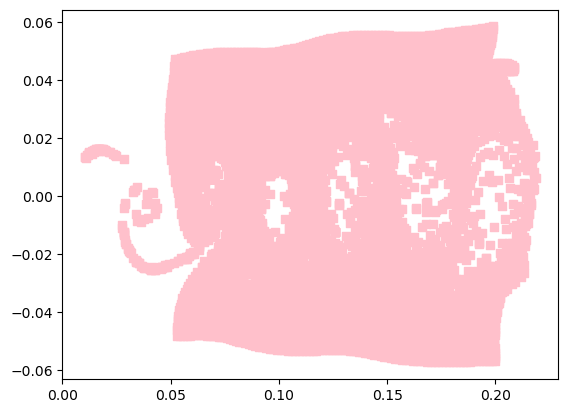

PyObject <matplotlib.collections.PathCollection object at 0x0000023574463730>

In [25]:
fig, ax = subplots()
ts = 101
ax.scatter(p[1,ts,:,:],p[2,ts,:,:],marker="s",color="pink",zorder=3)
#ax.set_xlim([9.5,12])
#ax.set_ylim([  9,11])

In [26]:
function xflowMap(field, tstep, levels)
    x = field[1,1,:,:]
    y = field[2,1,:,:]
    z = field[1,tstep,:,:]
    fig, ax = subplots(figsize=(9.25,5.25))
    cm = ax.contourf(x,y,z,cmap=ColorMap("rainbow"),levels=levels)
    fig.colorbar(cm)
    title("Flow Map at "*string((tstep-1)*tstep_delta+tstep_start) *"ms")
end

xflowMap (generic function with 1 method)

In [30]:
function ff(field, tstep)
    x = field[1,1,:,:]
    y = field[2,1,:,:]
    z = field[3,tstep,:,:]
    fig, ax = subplots(figsize=(9.25,5.25))
    cm = ax.contourf(x,y,z,cmap=ColorMap("rainbow"))
    fig.colorbar(cm)
    title("Flow Map at "*string((tstep-1)*tstep_delta+tstep_start) *"ms")
end

ff (generic function with 1 method)

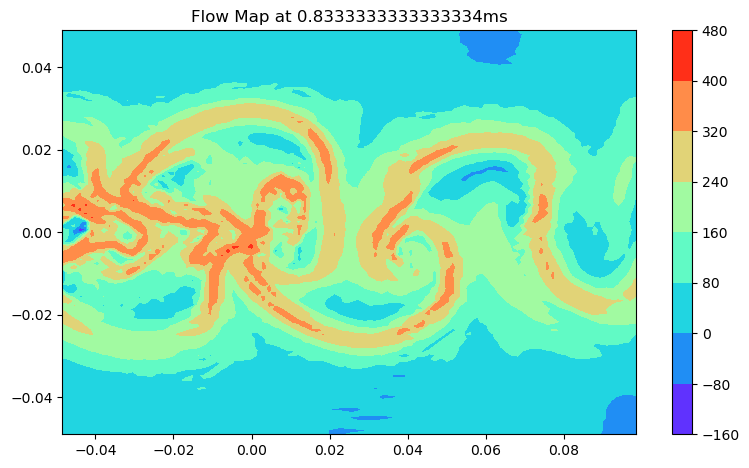

PyObject Text(0.5, 1.0, 'Flow Map at 0.8333333333333334ms')

In [31]:
ff(p, 101)

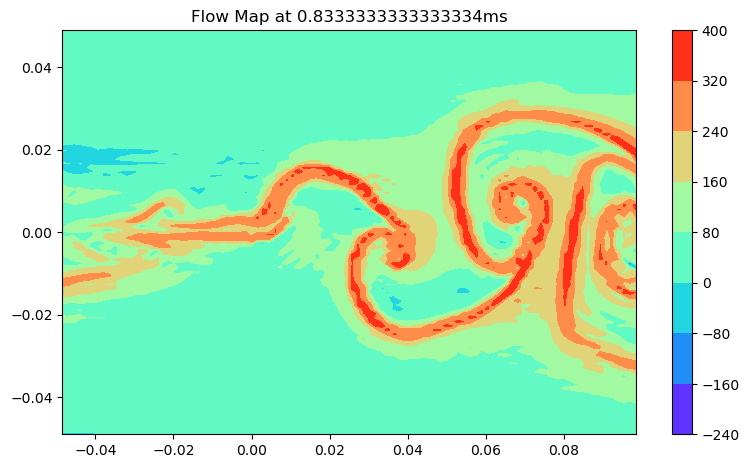

PyObject Text(0.5, 1.0, 'Flow Map at 0.8333333333333334ms')

In [32]:
ff(n, 101)

In [27]:
function filterFTLE(field, limFTLE)
    manifolds = (field[3,:,:,:] .> limFTLE * maximum(field[3,:,:,:])) .|> Int
    return manifolds
end

filterFTLE (generic function with 1 method)

In [28]:
function ftle(pos, neg, tstep)
    x = pos[1,1,:,:]
    y = pos[2,1,:,:]
    p = filterFTLE(pos, 0.5)
    n = filterFTLE(neg, 0.67)
    fig, ax = subplots(figsize=(9.25,5.25))
    levels = range(0, 1,length=3) .+ 0.5
    ax.contourf(x[:,:],y[:,:],p[tstep,:,:],cmap=ColorMap("Blues"),levels=levels, alpha=0.5, zorder=1)
    ax.contourf(x[:,:],y[:,:],n[tstep,:,:],cmap=ColorMap("Reds") ,levels=levels, alpha=0.5, zorder=2)
end

ftle (generic function with 1 method)

In [ ]:
function ftle(p, n, lim, ts, save, t, tar)
    x = p[1,1,:,:]
    y = p[2,1,:,:]
    pos = (p[3,ts,:,:] .> lim * maximum(p[3,ts,:,:])) .|> Int
    neg = (n[3,ts,:,:] .> lim * maximum(n[3,ts,:,:])) .|> Int
    fig, ax = subplots(figsize=(18.5,10.5))
    levels = range(0, 1,length=3) .+ 0.5
    ax.contourf(x,y,pos,cmap=ColorMap("Blues"),levels=levels, alpha=0.5, zorder=1)
    ax.contourf(x,y,neg,cmap=ColorMap("Reds") ,levels=levels, alpha=0.5, zorder=2)
    if save == true
        name = string(t) * "_" * string(tar) * ".png"
        savefig(joinpath(sdata, name), dpi=100)
        close()
    end
end

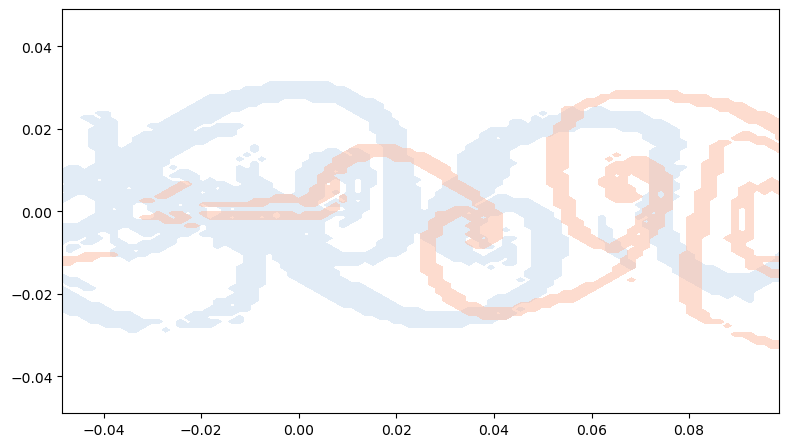

PyObject <matplotlib.contour.QuadContourSet object at 0x00000235744C3FA0>

In [29]:
ftle(p, n, 101)

In [ ]:
size(n3)

In [ ]:
function sc(o, t, save=false)
    fig, ax = subplots(figsize=(18.5,10.5))
    levels = range(0, 1,length=3) .+ 0.5
    #cm = ax.scatter(o[1,1,:,:],o[2,1,:,:],o[1,t,:,:], cmap=ColorMap("rainbow"), levels=levels)
    #fig.colorbar(cm)
    ax.scatter(o[1,t,:,:],o[2,t,:,:],marker="s",color="pink",zorder=3, alpha=0.1)
    #title("Flow Map at "*string(move*(t-1)*tstep_delta+t_0) *"ms")
    if save == true
        savefig(joinpath(data, name * string(t) * ".png"), dpi=100)
        close()
    end
end

In [ ]:
sc(p3, 27)

In [ ]:
function fm(o, t, levels, save=false)
    fig, ax = subplots(figsize=(18.5,10.5))
    cm = ax.contourf(o[1,1,:,:],o[2,1,:,:],o[1,t,:,:], cmap=ColorMap("rainbow"), levels=levels)
    fig.colorbar(cm)
    #title("Flow Map at "*string(move*(t-1)*tstep_delta+t_0) *"ms")
    if save == true
        savefig(joinpath(data, name * string(t) * ".png"), dpi=100)
        close()
    end
end

In [ ]:
size(n2)

In [ ]:
ftle(p2, n2, 52)

In [ ]:
fm(p3,,range(-0.05,0.2,length=50))

In [ ]:
data =  "C:/Users/jjser/Desktop/Julia_FTLE_Karthik_Data/airfoil2D_f0.15_amp25deg_KM/data_JJ"
sdata =  "C:/Users/jjser/Desktop/Julia_FTLE_Karthik_Data/airfoil2D_f0.15_amp25deg_KM/plots_JJ/69800_3000_250"
t = 69800
d = 200
r = 6000
n = Int(0.5*r/d)
for ii in -n:n 
    tar = t + ii * d
    name = "p" * string(t) * "_" * string(tar) * ".h"
    p = h5open(joinpath(data,name), "r") do file
        read(file, "A")
    end
    name = "n" * string(t) * "_" * string(tar) * ".h"
    n = h5open(joinpath(data,name), "r") do file
        read(file, "A")
    end
    ftle(p, n, 0.8, 122, true, t, tar)
end
print("DONE")

In [ ]:
data =  "C:/Users/jjser/Desktop/Julia_FTLE_Karthik_Data/Yuanhang/data_JJ"
name = "xR.h"
h5open(joinpath(data,name), "w") do file
    write(file, "A", x_range)
end
name = "yR.h"
h5open(joinpath(data,name), "w") do file
    write(file, "A", y_range)
end
name = "VelData.h"
h5open(joinpath(data,name), "w") do file
    write(file, "A", Vel_contour)
end

In [ ]:
name = "VelData.h"
h5open(joinpath(data,name), "w") do file
    write(file, "A", Vel_contour)
end

In [ ]:
gif_arr = ones(RGB{N0f8}, (1050, 1850, 31)) 
sdata =  "C:/Users/jjser/Desktop/Julia_FTLE_Karthik_Data/Yuanhang/plots_JJ"

for frame in 1:27
    tar = copy(frame)
    name = string(t) * "_" * string(tar) * ".png"
    im = load(joinpath(sdata, name))
    gif_arr[:,:,frame] = im
end

name = "69800_3000_250gif.gif"
save(joinpath(sdata, name), gif_arr)
print("DONE")